## Training an LLM

In [1]:
import torch 
from IPython.display import Image
import sys
sys.path.append('../GPT_Architecture/')
from GPT_Model import *
from generate_text import *

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [3]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_feature

In [4]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # .unsqueeze(0) adds the batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # Removes batchdimension
    return tokenizer.decode(flat.tolist())

In [5]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model= model,
    idx = text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you Aeiman Byeswickattributeometer inspector Normandy freezerigrate


The model is not producing coherent text yet since it hasn't been trained. To define what maskes text "coherent"we have to implement a numerical method to evaluate the generated content. This approach will enable us to monitor and enhance the model's performance.

Next, we will calculate a loss metric for the generated outputs. This loss serves as a progress and sucess indicator of the training progress. 

In [6]:
inputs = torch.tensor([[16833, 3626, 6100], [40, 1107, 588]])
targets = torch.tensor([[3626, 6100, 345 ], [1107, 588, 11311]])

with torch.no_grad():
    logits = model(inputs)
    probas = torch.softmax(logits, dim=-1)
    print(probas.shape)

torch.Size([2, 3, 50257])


In [7]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[36397],
         [39619],
         [20610]],

        [[ 8615],
         [49289],
         [47105]]])


In [8]:
text_idx = 0
target_probas_1 = probas[text_idx,[0,1,2], targets[text_idx]]

text_idx = 1
target_probas_2 = probas[text_idx, [0,1,2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 2: tensor([4.2794e-05, 1.6248e-05, 1.1586e-05])


Next, we will calculate the loss for the probability scores of the two example batches,
target_probas_1 and target_probas_2

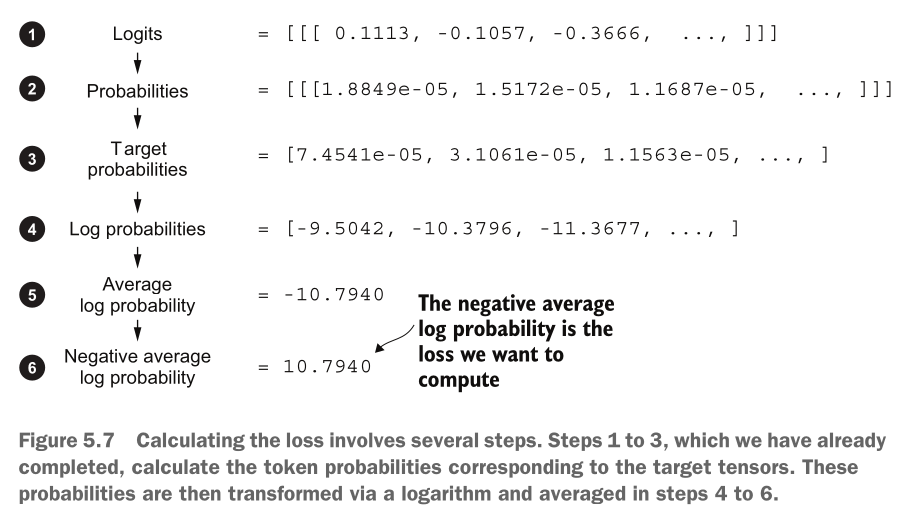

In [9]:
Image('./Screenshot from 2025-05-28 21-02-02.png')

In [10]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([-10.6600, -10.7936, -11.3531, -10.0591, -11.0276, -11.3658])


Working with the logarithms of probability scores is more managable in mathematical optimization than handlging scores directly.

In [11]:
avg_log_probas = torch.mean(log_probas)

In [12]:
print(avg_log_probas)

tensor(-10.8765)


In [13]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.8765)


In deep learning, the term for turning this negative
value, –10.7940, into 10.7940, is known as the cross entropy loss. PyTorch comes in
handy here, as it already has a built-in cross_entropy function that takes care of all
these six steps in figure 5.7 for us.

Before we apply the cross_entropy function, let’s briefly recall the shape of the logits
and target tensors:

In [14]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


For the cross_entropy loss function in PyTorch, we want to flatten these tensors by combining them over the batch dimension:

In [15]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [16]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.8765)


## Calculating the training and validation set losses

We must prepare the training and validation sets. Then we will calculate the cross entropy for the training and validation sets.

To compute the loss, on the training and validation we use "The Verdict" by Edith Wharton

In [17]:
file_path = "../data_preparation/the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [18]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


Now we divide the dataset into training and validation sets and use the data loaders from chapter to prepare the batches for training the LLM.

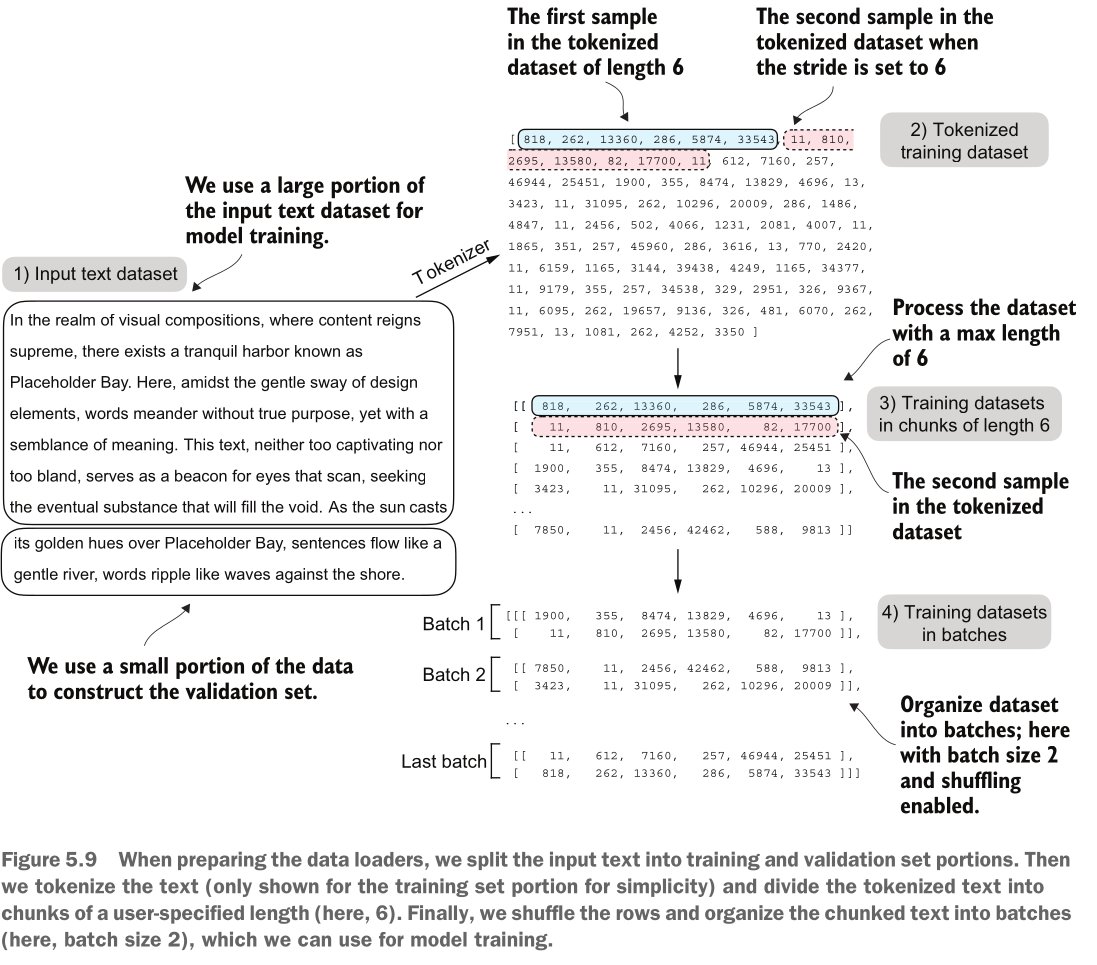

In [19]:
Image('./Screenshot from 2025-05-29 11-58-07.png')

In [20]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(txt)

        for i in range(0, len(token_ids) - max_length, stride): # Sliding window to divide the book into overlapping sequences of max length
            input_chunk = token_ids[i: i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    # return size of dataset 
    def __len__(self):
        return len(self.input_ids)

    # return single row from dataset
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)
    return dataloader

In [22]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [23]:
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)


val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

We used a relatively small batch size to reduce the computational resource demand
because we were working with a very small dataset. In practice, training LLMs with
batch sizes of 1,024 or larger is not uncommon.

In [24]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])


Next, we implement a utility function to calculate the cross entropy loss of a given
batch returned via the training and validation loader:

In [25]:
def cal_loss_batch(input_batch, target_batch, model, device):
    # the transfer to a given device allows us to transfer the data to the gpu
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten())
    return loss
    

calc_loss_loader computes the loss over all the batches sampled by a given data loader.

In [26]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
        
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader) # iterate over all batches if no num of batches is specified
    else: 
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = cal_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches # Averages the loss over all batches

By default the function above iterates over all batches in a given data loader, accumulates the loss in the total_loss variable, and the computes and averages the loss over the total number of batches. Alternatively, we can specify a
smaller number of batches via num_batches to speed up the evaluation during model
training.

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98850154876709
Validation loss: 10.99034309387207


The loss values are relatively high because the model has not yet been trained. For
comparison, the loss approaches 0 if the model learns to generate the next tokens as
they appear in the training and validation sets.

## Training an LLM

The figure below illustrates a typical PyTorch neural network training workflow.

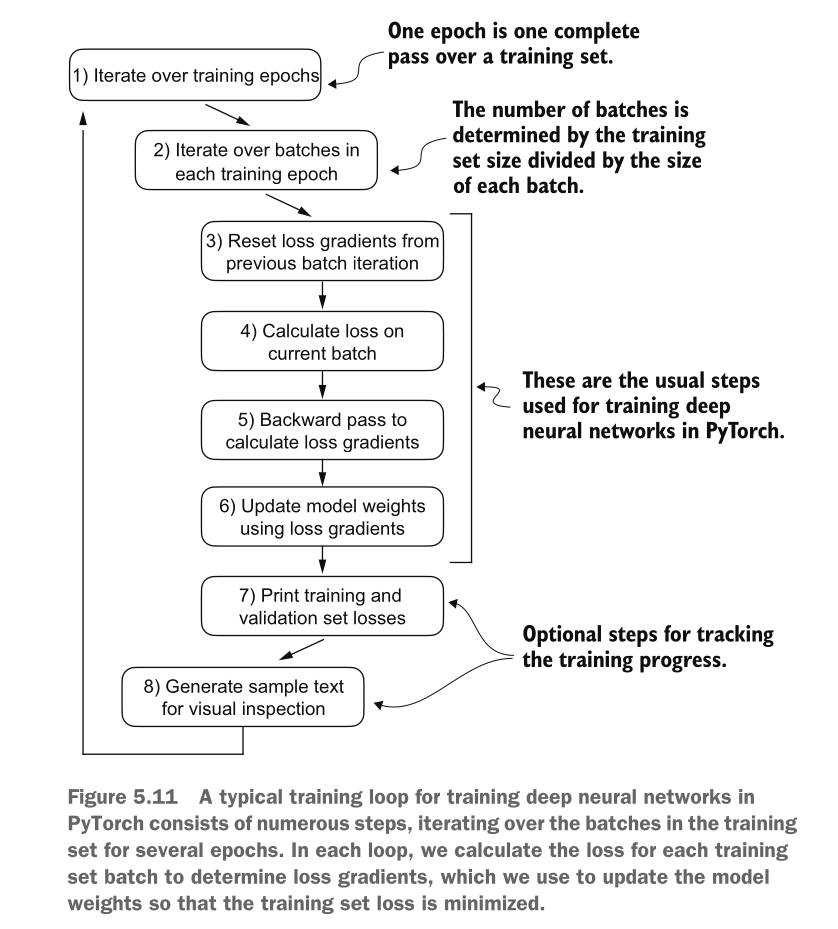

In [28]:
Image('./Screenshot from 2025-05-29 12-48-57.png')

In [29]:
def train_model_simple(model,train_loader, val_loader, optimizer, device, 
                       num_epochs, eval_freq, eval_iter,  start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader: 
            optimizer.zero_grad()  # Resets loss gradients from the previous batch iteration
            loss = cal_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculates loss gradients 
            optimizer.step() # Updates model weights using loss gradients 
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0: # optional evaluation step
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)

                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}")
        generate_and_print_sample(model, tokenizer, device, start_context )
        
    return train_losses, val_losses, track_tokens_seen

The evaluate_model function calculates the loss over the training and validation set while ensuring the model is in evaluation mode with gradient tracking  and dropout disabled when calculating the loss over the training and validation sets:

In [30]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader( val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

Similar to evaluate_model, the generate_and_print_sample function is a convenience
function that we use to track whether the model improves during the training. In partic-
ular, the generate_and_print_sample function takes a text snippet (start_context) as
input, converts it into token IDs, and feeds it to the LLM to generate a text sample
using the generate_text_simple function we used earlier:

In [31]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()  # Set model to evaluation mode

    context_size = model.pos_emb.weight.shape[0]  # Get the max context size
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    # Add batch dimension with .unsqueeze(0) → shape [1, seq_len]

    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model,
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size
        )

    decoded_text = token_ids_to_text(token_ids[0], tokenizer)  # [0] to remove batch dim
    print(decoded_text.replace("\n", " "))

    model.train()  # Return model to training mode


In [40]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 10

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.781, Val loss 9.933
Ep 1 (Step 000005): Train loss 8.111, Val loss 8.339
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.661, Val loss 7.048
Ep 2 (Step 000015): Train loss 5.961, Val loss 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Step 000020): Train loss 5.726, Val loss 6.600
Ep 3 (Step 000025): Train loss 5.201, Val loss 6.348
Every effort moves you, and I had been.                                            
Ep 4 (Step 000030): Train loss 4.417, Val loss 6.278
Ep 4 (Step 000035): Train loss 4.069, Val loss 6.226
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Ep 5 (Step 000040): Train loss 3.732, Val loss 6.160
Every effort moves you know it was not that the picture--I had the fact by the last

Before discussing the validation loss in more detail, let’s create a simple plot that
shows the training and validation set losses side by side:

In [32]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import torch

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(6, 4))

    # Plot training and validation loss vs epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Add second x-axis to show tokens seen
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)  # invisible plot to align ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    plt.show()

# Example usage
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)


NameError: name 'num_epochs' is not defined

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

This divergence and the fact that the
validation loss is much larger than the training loss indicate that the model is overfit-
ting to the training data. We can confirm that the model memorizes the training data
verbatim by searching for the generated text snippets, such as quite insensible to
the irony in the “The Verdict” text file.

This memorization is expected since we are working with a very, very small training
dataset and training the model for multiple epochs. Usually, it’s common to train a
model on a much larger dataset for only one epoch.

## Decoding strategies to control randomness

Let’s look at text generation strategies  to generate
more original text. First, we will briefly revisit the generate_text_simple function that
we used inside generate_and_print_sample earlier.

In [33]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_feature

In [34]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you Aeiman Byeswickattributeometer inspector Normandy freezerigrate McAuliffe siph681 presentlyAverage Rates questionable authentication Prelude editsisi Australians papers beginnings DX


## Temperature scaling

Let's now look at temperature scaling, a technique that adds a porbabilistic selection process to the next-token generation task. Previously, inside the generate_text_simple function,  we always sampled the token with the highest probability as the next token using torch.argmax, also known as greedy decoding. To generate text with more variety, we can replace argmax with a function that samples from a probability distribution (here, the probability scores the LLM generates for each vocabulary entry at each
token generation step)

In [35]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

In [36]:
inverse_vocab = {v: k for k, v in vocab.items()}

Next, assume the LLM is given the start context "every effort moves you" and gener-
ates the following next-token logits:

In [37]:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

To implement a probabilistic sampling process, we can now replace argmax with the multinomial function in PyTorch:

In [38]:
probas = torch.softmax(next_token_logits, dim=0)

torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


The multinomial
function samples the next token proportional to its probability score. In other words,
"forward" is still the most likely token and will be selected by multinomial most of
the time but not all the time.

We can further control the distribution and selection process via a concept called temperature scaling. Temperature scaling is just a fancy description for dividing the logits by a number greater than 0:

In [39]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

Temperatures greater than one result in more uniformly distributed token probabilities, and temperatures smaller than 1 will result in more confident (sharper or more peaky)
distributions.

## Top-k sampling 

Top-k sampling, when combined with probabilistic sampling and temperature scal-
ing, can improve the text generation results. In top-k sampling, we can restrict the
sampled tokens to the top-k most likely tokens and exclude all other tokens from the
selection process by masking their probability scores,

In [40]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


Subsequently, we apply PyTorch’s where function to set the logit values of tokens that are
below the lowest logit value within our top-three selection to negative infinity

In [41]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],  #identifies logits less than the minimum in top 3
    input= torch.tensor(float('-inf')),
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [42]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


We can now apply the temperature scaling and multinomial function for probabilistic
sampling to select the next token among these three non-zero probability scores to
generate the next token. We do this next by modifying the text generation function.

In [43]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
        if temperature > 0.0: 
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else: 
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx
            

In [44]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size = GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

In [45]:
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you JCFord Run Rates gorePutting Settlement 330encingSee Cruiser41 international donatedabsolute


## Loading and saving model weights in PyTorch

Even though both the LLM and dataset were relatively
small, this exercise showed that pretraining LLMs is computationally expensive. Thus,
it is important to be able to save the LLM so that we don’t have to rerun the training
every time we want to use it in a new session.

So, let’s discuss how to save and load a pretrained model. Later, we will load a more capable pretrained GPT model from OpenAI into
our GPTModel instance.

Fortunately, saving a PyTorch model is relatively strightforward. The recommended way is to save a model's state_dic, a dictionary mapping each layer to its parameters, using the torch.save() function

In [46]:
torch.save(model.state_dict(), "model.pth")

after saving the model weights via the state_dict, we can load the model
weights into a new GPTModel model instance:

In [47]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval()

RuntimeError: Error(s) in loading state_dict for GPTModel:
	size mismatch for pos_emb.weight: copying a param with shape torch.Size([1024, 768]) from checkpoint, the shape in current model is torch.Size([256, 768]).
	size mismatch for trf_blocks.0.att.mask: copying a param with shape torch.Size([1024, 1024]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for trf_blocks.1.att.mask: copying a param with shape torch.Size([1024, 1024]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for trf_blocks.2.att.mask: copying a param with shape torch.Size([1024, 1024]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for trf_blocks.3.att.mask: copying a param with shape torch.Size([1024, 1024]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for trf_blocks.4.att.mask: copying a param with shape torch.Size([1024, 1024]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for trf_blocks.5.att.mask: copying a param with shape torch.Size([1024, 1024]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for trf_blocks.6.att.mask: copying a param with shape torch.Size([1024, 1024]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for trf_blocks.7.att.mask: copying a param with shape torch.Size([1024, 1024]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for trf_blocks.8.att.mask: copying a param with shape torch.Size([1024, 1024]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for trf_blocks.9.att.mask: copying a param with shape torch.Size([1024, 1024]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for trf_blocks.10.att.mask: copying a param with shape torch.Size([1024, 1024]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for trf_blocks.11.att.mask: copying a param with shape torch.Size([1024, 1024]) from checkpoint, the shape in current model is torch.Size([256, 256]).

If we plan to continue pretraining a model later saving the optimizer state is also recommended. Adaptive optmizers like AdamW store additional parameters for each model weight. AdamW uses historical data to adjust learning rates for each model parameter dynamically. Without it, the optimizer resets, and the model may learn suboptimally
or even fail to converge properly, which means it will lose the ability to generate coherent text. Using torch.save, we can save both the model and optimizer state_dict
contents:

In [ ]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
},
              "model_and_optimizer.pth"
)

Then we can restore the model and optimizer states by first loading the saved data via torch.load and then using the load_state_dict method:

In [ ]:
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

## Loading pretrained weights from OpenAI

Note that OpenAI originally saved the GPT-2 weights via TensorFlow, which we have to install to load the weights in Python.

In [61]:
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch05/01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x78b8a82a3a70>)

In [62]:
from gpt_download import download_and_load_gpt2
settings, params =  download_and_load_gpt2(model_size="124M", models_dir="gpt2")

2025-05-30 11:38:10.323401: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-30 11:38:10.330948: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748619490.339218   17963 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748619490.341678   17963 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748619490.348117   17963 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [63]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [64]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


We downloaded and loaded the weights of the smallest GPT-2 model via the download_ and_load_gpt2(model_size="124M", ...) setting. OpenAI also shares the weights of
larger models: 355M, 774M, and 1558M. The overall architecture of these differently
sized GPT models is the same, except that different architectural elements are repeated different numbers of times and the embedding
size differs.

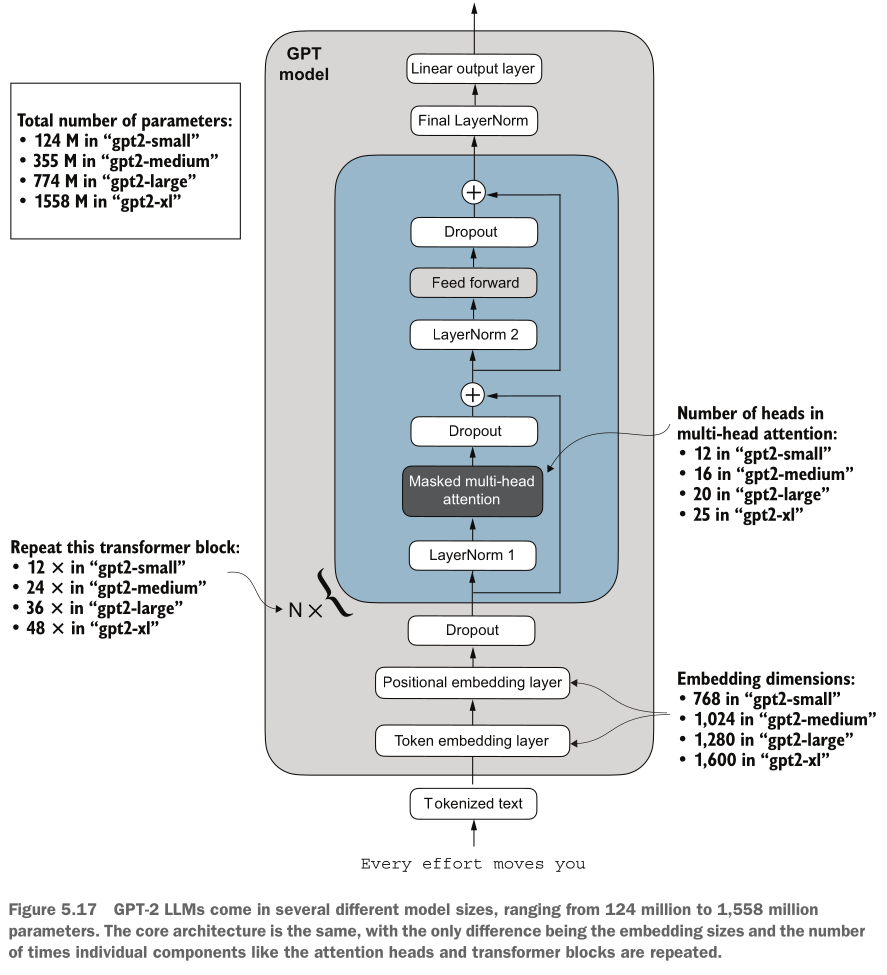

In [65]:
Image('./Screenshot from 2025-05-30 11-05-46.png')

First, we cre-
ate a dictionary that lists the differences between the different GPT model sizes

In [66]:
model_configs = {
"gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
"gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
"gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
"gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

Suppose we are interested in loading the smallest model,

In [67]:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024})

Also, OpenAI used bias vectors in the multi-head attention module’s linear layers to
implement the query, key, and value matrix computations. Bias vectors are not com-
monly used in LLMs anymore as they don’t improve the modeling performance and
are thus unnecessary. However, since we are working with pretrained weights, we need
to match the settings for consistency and enable these bias vectors:

In [68]:
NEW_CONFIG.update({"qkv_bias": True})

In [69]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

By default, the GPTModel instance is initialized with random weights for pretraining.
The last step to using OpenAI’s model weights is to override these random weights
with the weights we loaded into the params dictionary. For this, we will first define a
small assign utility function that checks whether two tensors or arrays (left and
right) have the same dimensions or shape and returns the right tensor as trainable
PyTorch parameters:

In [71]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

Next, we define a load_weights_into_gpt function that loads the weights from the
params dictionary into a GPTModel instance gpt.

In [72]:
import numpy as np

# Sets the model’s positional and token embedding weights to those specified in params.
def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    # The original GPT-2 model by OpenAI reused the token embedding weights in the
    # output layer to reduce the total number of parameters, which is a concept known as weight tying.
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


Developing the load_weights_into_gpt function took a lot of guesswork since
OpenAI used a slightly different naming convention from ours. However, the assign
function would alert us if we try to match two tensors with different dimensions. Also,
if we made a mistake in this function, we would notice this, as the resulting GPT
model would be unable to produce coherent text.

In [73]:
load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [74]:
torch.manual_seed(123)
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?


